- 당뇨 유무 비율 맞추기

In [1]:
import numpy as np
import pandas as pd
#from preprocess1121 import preproc, get_X, g_testX, get_y
import torch
from torch.autograd import Variable
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# train = pd.read_csv('./data/train.csv', index_col=0)
# validation = pd.read_csv('./data/validation.csv', index_col=0)
# test = pd.read_csv('./data/test.csv', index_col=0)

origin_df = pd.read_csv('./data/origin_df.csv', index_col=0)

In [3]:
# 당뇨가 아닌 데이터 중에서 41767개를 선택하는 부분입니다.
# 클래스 'D'가 0인 경우(당뇨가 아닌 경우)의 데이터를 최대 41767개까지 선택합니다.
origin_0 = origin_df.loc[origin_df['D'] == 0].head(41767)
# 클래스 'D'가 1인 경우(당뇨인 경우)의 모든 데이터를 선택합니다.
origin_1 = origin_df.loc[origin_df['D'] == 1]
# 당뇨가 아닌 경우와 당뇨인 경우의 데이터를 합쳐서 새로운 데이터프레임을 만듭니다.
origin_df = pd.concat([origin_0, origin_1])
# 클래스 'D'의 값 분포를 확인합니다.
origin_df['D'].value_counts()

D
0    41767
1    41767
Name: count, dtype: int64

In [4]:
origin_df.head()
origin_df.tail()

,HCHK_YEAR,IDV_ID,SIDO,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,...,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTH_MSS_YN,ODT_TRB_YN,WSDM_DIS_YN,TTR_YN,DATA_STD_DT,D
999978,2021,3657455,28,2,13,155,80,104.0,1.0,0.0,...,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11,1
999981,2021,1298369,11,2,11,155,55,80.0,0.0,0.0,...,1.0,0.0,1,1.0,NaN,NaN,NaN,0.0,2022-08-11,1
999982,2021,99706,41,2,13,150,65,97.0,1.0,1.0,...,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11,1
999983,2021,2138612,11,2,13,155,95,112.0,0.0,0.0,...,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11,1
999993,2021,4123914,28,1,12,170,80,93.0,0.0,0.0,...,2.0,0.0,1,0.0,NaN,NaN,NaN,1.0,2022-08-11,1


In [5]:
# BMI(체질량지수)를 계산하여 데이터프레임에 새로운 열('BMI')로 추가
origin_df['BMI'] = origin_df['WEIGHT'] / ((origin_df['HEIGHT'])/100)**2

In [6]:
#  'BLDS' 첫 번째 열로 이동
origin_df.insert(0, 'BLDS', origin_df.pop('BLDS'))

In [7]:
# 'BP_HIGH' 제거
origin_df = origin_df.drop(['BP_HIGH'], axis=1)

In [8]:
# 'TOT_CHOLE' 제거
origin_df = origin_df.drop(['TOT_CHOLE'], axis=1)

In [9]:
# 'DATA_STD_DT' 제거
origin_df = origin_df.drop(['DATA_STD_DT'], axis=1)

In [10]:
# 'HCHK_YEAR', 'IDV_ID','SIDO','HEIGHT','WEIGHT','WAIST','SIGHT_LEFT','SIGHT_RIGHT','HEAR_LEFT','HEAR_RIGHT','SGOT_AST','DRK_YN' 제거

origin_df = origin_df.drop(columns=['HCHK_YEAR', 'IDV_ID','SIDO','HEIGHT','WEIGHT','WAIST','SIGHT_LEFT','SIGHT_RIGHT','HEAR_LEFT','HEAR_RIGHT','SGOT_AST','DRK_YN'])


# 'TTR_YN', 'WSDM_DIS_YN','ODT_TRB_YN','TTH_MSS_YN','CRS_YN', 'HCHK_OE_INSPEC_YN' 제거
origin_df = origin_df.drop(columns=['TTR_YN', 'WSDM_DIS_YN','ODT_TRB_YN','TTH_MSS_YN','CRS_YN', 'HCHK_OE_INSPEC_YN'])#치아 관련

In [11]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83534 entries, 574465 to 999993
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BLDS              83534 non-null  float64
 1   SEX               83534 non-null  int64  
 2   AGE_GROUP         83534 non-null  int64  
 3   BP_LWST           83533 non-null  float64
 4   TRIGLYCERIDE      83534 non-null  float64
 5   HDL_CHOLE         83534 non-null  float64
 6   LDL_CHOLE         83534 non-null  float64
 7   HMG               83534 non-null  float64
 8   OLIG_PROTE_CD     83534 non-null  float64
 9   CREATININE        83534 non-null  float64
 10  SGPT_ALT          83534 non-null  float64
 11  GAMMA_GTP         83534 non-null  float64
 12  SMK_STAT_TYPE_CD  83501 non-null  float64
 13  D                 83534 non-null  int64  
 14  BMI               83534 non-null  float64
dtypes: float64(12), int64(3)
memory usage: 10.2 MB


In [12]:
# 데이터를 섞습니다.
origin_df = origin_df.sample(frac=1).reset_index(drop=True)

In [13]:
# 테스트 데이터, 검증 데이터, 학습 데이터로 나눕니다.

test_df = origin_df.tail(10000)
val_df = origin_df.head(73534).tail(10000)
origin_df = origin_df.head(63534)

In [14]:
print(origin_df.tail())
print(val_df.head())

        BLDS  SEX  AGE_GROUP  BP_LWST  TRIGLYCERIDE  HDL_CHOLE  LDL_CHOLE  \
63529   77.0    2         10     75.0          53.0       74.0      129.0   
63530  102.0    1          9     77.0         209.0       49.0      142.0   
63531  140.0    1         12     70.0         230.0       49.0      118.0   
63532  117.0    2         11     70.0          95.0       86.0      150.0   
63533  123.0    1          9     88.0         122.0       62.0      107.0   

        HMG  OLIG_PROTE_CD  CREATININE  SGPT_ALT  GAMMA_GTP  SMK_STAT_TYPE_CD  \
63529  10.0            1.0         0.0      16.0       12.0               1.0   
63530  13.0            1.0         0.0      16.0       23.0               2.0   
63531  15.0            1.0         0.0      53.0      127.0               2.0   
63532  13.0            1.0         0.0      16.0       25.0               1.0   
63533  16.0            2.0         0.0      15.0       53.0               3.0   

       D        BMI  
63529  0  18.730489  
63530 

In [15]:
# 각각의 데이터프레임(test_df, val_df, origin_df)에 대해 누락된 값(null 또는 NaN)이 각 열별로 얼마나 있는지를 확인합니다. 코드의 결과를 통해 데이터의 결측치 여부를 파악

print(test_df.isnull().sum())
print(val_df.isnull().sum())
print(origin_df.isnull().sum())

BLDS                0
SEX                 0
AGE_GROUP           0
BP_LWST             0
TRIGLYCERIDE        0
HDL_CHOLE           0
LDL_CHOLE           0
HMG                 0
OLIG_PROTE_CD       0
CREATININE          0
SGPT_ALT            0
GAMMA_GTP           0
SMK_STAT_TYPE_CD    7
D                   0
BMI                 0
dtype: int64
BLDS                0
SEX                 0
AGE_GROUP           0
BP_LWST             0
TRIGLYCERIDE        0
HDL_CHOLE           0
LDL_CHOLE           0
HMG                 0
OLIG_PROTE_CD       0
CREATININE          0
SGPT_ALT            0
GAMMA_GTP           0
SMK_STAT_TYPE_CD    3
D                   0
BMI                 0
dtype: int64
BLDS                 0
SEX                  0
AGE_GROUP            0
BP_LWST              1
TRIGLYCERIDE         0
HDL_CHOLE            0
LDL_CHOLE            0
HMG                  0
OLIG_PROTE_CD        0
CREATININE           0
SGPT_ALT             0
GAMMA_GTP            0
SMK_STAT_TYPE_CD    23
D              

In [16]:
# origin_df, val_df, test_df 데이터프레임에서 결측치를 포함한 행을 제거하는 작업
origin_df = origin_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

In [17]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63510 entries, 0 to 63533
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BLDS              63510 non-null  float64
 1   SEX               63510 non-null  int64  
 2   AGE_GROUP         63510 non-null  int64  
 3   BP_LWST           63510 non-null  float64
 4   TRIGLYCERIDE      63510 non-null  float64
 5   HDL_CHOLE         63510 non-null  float64
 6   LDL_CHOLE         63510 non-null  float64
 7   HMG               63510 non-null  float64
 8   OLIG_PROTE_CD     63510 non-null  float64
 9   CREATININE        63510 non-null  float64
 10  SGPT_ALT          63510 non-null  float64
 11  GAMMA_GTP         63510 non-null  float64
 12  SMK_STAT_TYPE_CD  63510 non-null  float64
 13  D                 63510 non-null  int64  
 14  BMI               63510 non-null  float64
dtypes: float64(12), int64(3)
memory usage: 7.8 MB


In [18]:
origin_df.D.value_counts()
#val_df.D.value_counts()
#test_df.D.value_counts()

D
1    31763
0    31747
Name: count, dtype: int64

<Axes: >

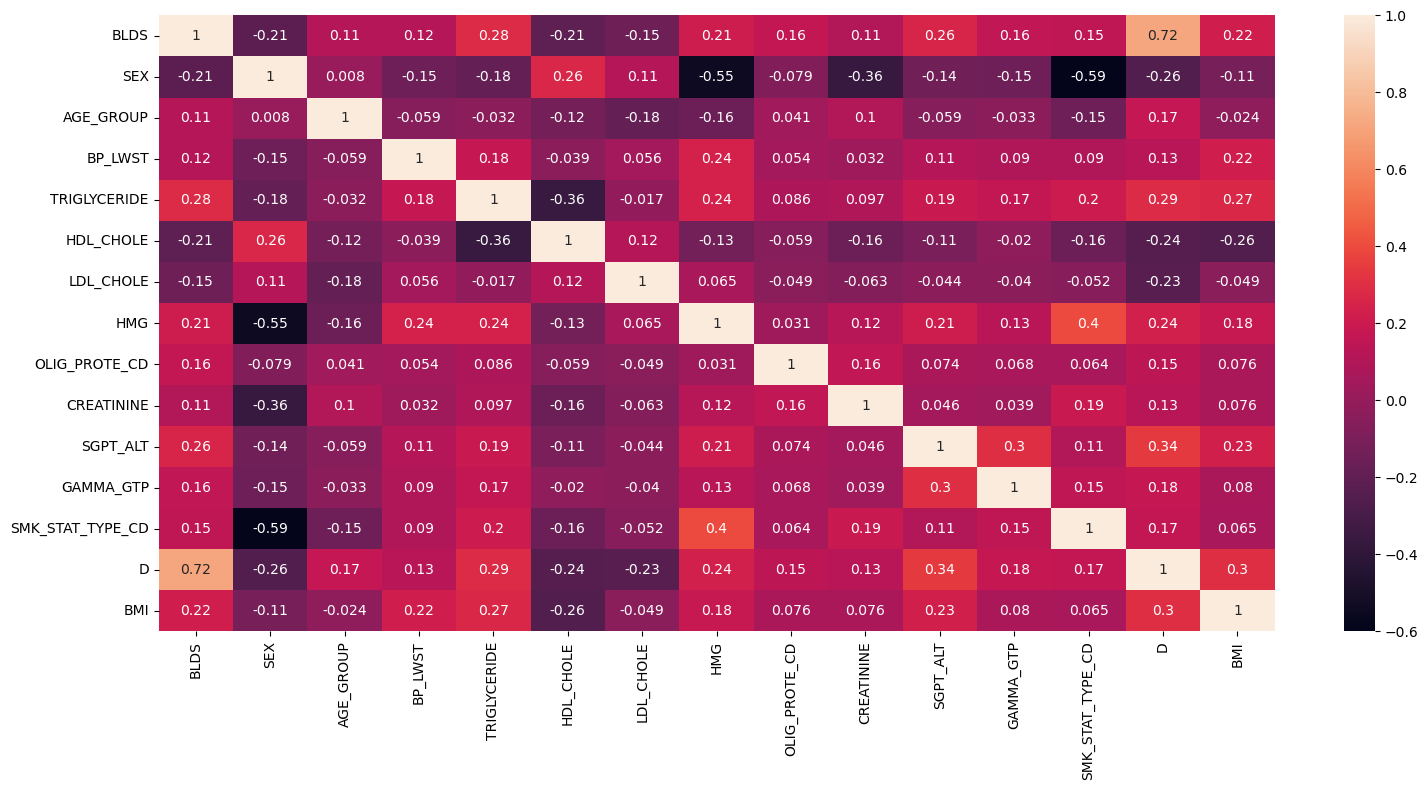

In [19]:
#sns.heatmap(train[['WEIGHT', 'BLDS']].corr())
#plt.scatter(train['WEIGHT'], train['BLDS'], s=3)
#plt.show()
plt.figure(figsize=(18,8))
corr = origin_df.corr()
#print(corr)
sns.heatmap(corr, annot=True, square=False, vmin=-0.6, vmax=1.0)

In [20]:
origin_df.to_csv('./data/train_df.csv')
val_df.to_csv('./data/validation_df.csv')
test_df.to_csv('./data/test_df.csv')